In [29]:

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import seaborn as sbn
import matplotlib.pyplot as plt

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from pylab import rcParams
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline
from sklearn.model_selection import LeaveOneOut, KFold



In [2]:
drink = pd.read_csv('strongdrink.txt')

In [55]:
#Question 1a)
X=drink[['alco', 'malic','tot_phen', 'color_int']]
y=drink[['cultivar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25,
                                                    random_state=20)

MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')

result = MultLogReg.fit(X_train, y_train)
print("When j=1, the coefficients are:", result.coef_[0], "and the intercept is:", result.intercept_[0])
print("When j=2, the coefficients are:", result.coef_[1], "and the intercept is:", result.intercept_[1])

When j=1, the coefficients are: [ 1.70042712 -0.26560793  1.22389494  0.02275111] and the intercept is: -24.0112762209
When j=2, the coefficients are: [-1.46801499 -0.33305178  0.6640073  -0.92271031] and the intercept is: 22.80207018


/Users/sumervaid/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
print("at j=1:", "b0=", result.intercept_[0], 'b1=', result.coef_[0][0], 'b2=', result.coef_[0][1], 'b3=',result.coef[0][2], 'b4=',result.coef[0][3])
y_pred=MultLogReg.predict(X_test)
confusion_matrix=confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[13  0  0]
 [ 2 19  0]
 [ 0  0 10]]


In [5]:
print(classification_report(y_test, y_pred, digits=3))
y_test=np.array([y_test["cultivar"]])

             precision    recall  f1-score   support

          1      0.867     1.000     0.929        13
          2      1.000     0.905     0.950        21
          3      1.000     1.000     1.000        10

avg / total      0.961     0.955     0.955        44



The predicted results are very similar for class 3 and for class 2, suggesting that the most accurately predicted category does not always have the most observations. As class 2 has a slightly smaller recall score, its predictions fare better than the other two classes by a small margin. 

In [59]:
#Question 1b)
Xvars = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink['cultivar'].values
N_loo=Xvars.shape[0]
loo=LeaveOneOut()
loo.get_n_splits(Xvars)
MSE=pd.DataFrame({'index':np.zeros(N_loo),
                                  'error':np.zeros(N_loo), 'y_pred':np.zeros(N_loo)})

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (((y_test - y_pred) ** 2) != 0).astype(int)
    MSE['y_pred'][test_index] = y_pred
    
error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
General = MSE['error'].mean()


print("Class 1 Error Rate:", error_1, 'Std is', MSE[MSE['y_pred']==1]['error'].std())
print("Class 2 Error Rate:", error_2, 'Std is', MSE[MSE['y_pred']==2]['error'].std())
print("Class 3 Error Rate:", error_3, 'Std is', MSE[MSE['y_pred']==3]['error'].std())
print("Average MSE Error Rate:", General, 'Std is', MSE['error'].std())

Class 1 Error Rate: 0.09836065573770492 Std is 0.3002730997379377
Class 2 Error Rate: 0.08571428571428572 Std is 0.2819629507400967
Class 3 Error Rate: 0.044444444444444446 Std is 0.20840907713999288
Average MSE Error Rate: 0.07954545454545454 Std is 0.2713602101199873


Compared to the earlier part a), the error rate for class 1 has reduced slightly but the error rate has increased for class 2 and class 3. The average mse is also bigger in this case as compared to part (a)

In [61]:
#Question 1c)
k=4
kf=KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
general_error_1=np.zeros(k)
general_error_2=np.zeros(k)
general_error_3=np.zeros(k)
general_mse=np.zeros(k)
k_ind=int(0)

for train_index, test_index in kf.split(Xvars):
    print('When k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE = pd.DataFrame({'error': (((y_test - y_pred) ** 2) != 0).astype(int), 
                    'y_pred': y_pred})
    error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
    error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
    error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
    error_all_class = MSE['error'].mean()
    general_error_1[k_ind] = error_1
    general_error_2[k_ind] = error_2
    general_error_3[k_ind] = error_3
    general_mse[k_ind] = error_all_class
    print('Class 1 Error Rate:', error_1,
          ', Class 2 Error Rate:', error_2,
          ', Class 3 Error Rate:', error_3)
    print('Value of MSE across classes: ', error_all_class)
    print('The STDEV is', MSE[MSE['y_pred'] == 1]['error'].std(),
          ',', MSE[MSE['y_pred'] == 2]['error'].std(),
          ',', MSE[MSE['y_pred'] == 3]['error'].std(),
          ',', MSE['error'].std(),'\n')
    
    k_ind += 1



print('Class 1 Average Error Rate:', general_error_1.mean(), ',Class 1 STDEV:', general_error_1.std())
print('Class 2 Average Error Rate:', general_error_2.mean(), ', Class 2 STDEV', general_error_2.std())
print('Class 3 Average Error Rate:', general_error_3.mean(), ', Class 3 STDEV:', general_error_3.std())
print('Average MSE for all Classes: ', general_mse.mean(), ', STDEV for all classes:', general_mse.std())



When k index= 0
Class 1 Error Rate: 0.29411764705882354 , Class 2 Error Rate: 0.0 , Class 3 Error Rate: 0.2222222222222222
Value of MSE across classes:  0.1590909090909091
The STDEV is 0.46966821831386213 , 0.0 , 0.44095855184409843 , 0.36998942902446835 

When k index= 1
Class 1 Error Rate: 0.0 , Class 2 Error Rate: 0.3125 , Class 3 Error Rate: 0.0
Value of MSE across classes:  0.11363636363636363
The STDEV is 0.0 , 0.47871355387816905 , 0.0 , 0.3210382206405504 

When k index= 2
Class 1 Error Rate: 0.0625 , Class 2 Error Rate: 0.0625 , Class 3 Error Rate: 0.0
Value of MSE across classes:  0.045454545454545456
The STDEV is 0.25 , 0.25 , 0.0 , 0.21070705494148548 

When k index= 3
Class 1 Error Rate: 0.11764705882352941 , Class 2 Error Rate: 0.0 , Class 3 Error Rate: 0.0
Value of MSE across classes:  0.045454545454545456
The STDEV is 0.3321055820775357 , 0.0 , 0.0 , 0.21070705494148548 

Class 1 Average Error Rate: 0.118566176471 ,Class 1 STDEV: 0.109567921799
Class 2 Average Error Rat

These error rates are very similar to those obtained by the leave-one-out method. The error rates obtained through K-fold and Leave-one-out class 1 are smaller as compared to part 1a). For class 2 and class 3, the error rates obtained through K-Fold and Leave-one-out are larger in the present question as compared to 1a). 

      Age  CoolIndex
0    11.0  10.981602
1    11.0  11.364925
2    11.0  10.190227
3    11.0   9.903725
4    11.0   8.997918
5    11.0   9.882644
6    11.0   9.658151
7    11.0  10.643767
8    11.0   9.975599
9    11.0   8.570520
10   11.0  12.783938
11   11.0   8.973262
12   11.0   9.506806
13   12.0   7.988456
14   12.0   8.578030
15   12.0   9.794792
16   12.0   9.459787
17   12.0  10.134268
18   12.0  10.195699
19   12.0   9.238065
20   12.0   9.647839
21   12.0   7.942515
22   12.0   9.757539
23   12.0   9.410136
24   12.0   9.481459
25   12.0  10.205661
26   12.0   9.284470
27   13.0  10.449850
28   13.0  10.611479
29   13.0   9.411983
..    ...        ...
926  82.0  26.006877
927  82.0  28.208319
928  82.0  33.435336
929  83.0  29.529285
930  83.0  29.241427
931  83.0  21.560181
932  84.0  22.159270
933  84.0  23.778112
934  84.0  28.647018
935  85.0  21.602050
936  85.0  24.282407
937  85.0  25.844704
938  86.0  26.027097
939  86.0  26.476684
940  86.0  22.232571
941  87.0  25

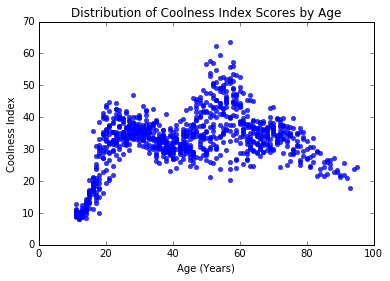

In [21]:
#Part 2a)
cool = pd.read_csv('CoolIndex.txt', header=None)
cool=cool.rename(columns={0:'Age', 1:'CoolIndex'})
plot=plt.axes()
print(cool)
sbn.regplot(x=cool['Age'],y=cool['CoolIndex'], fit_reg=False, ax=plot)
plot.set_title('Distribution of Coolness Index Scores by Age')
plot.set_xlabel('Age (Years)')
plot.set_ylabel('Coolness Index')

                            OLS Regression Results                            
Dep. Variable:               Coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 19 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        09:10:36   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
age11to22     20.1025      0.562     35.746      0.0

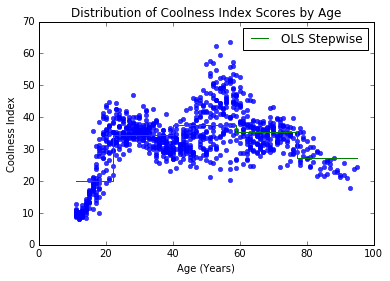

In [27]:
#Part 2b)
steps1=((age>=11)& (age<22)).astype(int)
steps2=((age>=22)& (age<40)).astype(int)
steps3=((age>=40)& (age<59)).astype(int)
steps4=((age>=59)& (age<77)).astype(int)
steps5=((age>=77)& (age<=95)).astype(int)

X_step=pd.DataFrame(dict(age11to22=steps1, age22to40=steps2, age40to59=steps3, age59to77=steps4, age77to95=steps5))
fit2=sm.OLS(endog=coolness, exog=X_step, missing='drop')
fit2_results=fit2.fit()
age_step=np.array([11, 22, 40, 59, 77, 95])
cool_step=fit2_results.params.tolist()+[fit2_results.params[-1]]

plot=plt.axes()
sbn.regplot(x=cool['Age'],y=cool['CoolIndex'], fit_reg=False, ax=plot)
plot.set_title('Distribution of Coolness Index Scores by Age')
plot.set_xlabel('Age (Years)')
plot.set_ylabel('Coolness Index')

plt.step(age_step, cool_step, where='post', label='OLS Stepwise')
plt.legend()
print(fit2_results.summary())
b1,b2,b3,b4,b5=fit2_results.params
print('b1=',b1, 'b2=',b2, 'b3=',b3, 'b4=',b4, 'b5=',b5)
print('The predicted coolness of a 73-year old is', fit2_results.params[3])



The predicted coolness of a 73-year old is 32.536832389143306


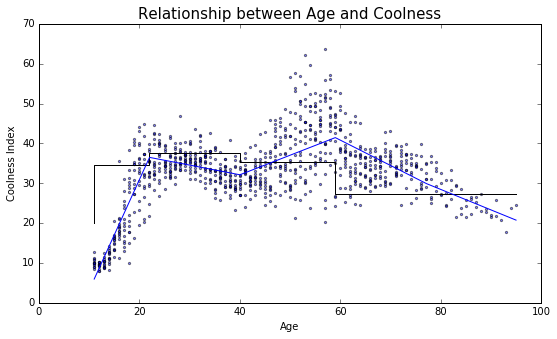

In [32]:
#Part 2c)
knots=[22,40,59,77]
spline_cool=LSQUnivariateSpline(age.values, coolness.values, knots, k=1)
fig=plt.figure(figsize=(9,5))
plt.scatter(age, coolness, s=5, alpha=0.5)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
plt.step(age_step, cool_step, 'k-', label="OLS Stepwise")
plt.plot(age_vec, spline_cool(age_vec), 'b-', label="Linear Spline")
plt.title("Relationship between Age and Coolness", fontsize=15)
plt.xlabel('Age')
plt.ylabel("Coolness Index")
print("The predicted coolness of a 73-year old is", spline_cool(73))

The predicted coolness of a 73-year old is 31.262429389257864


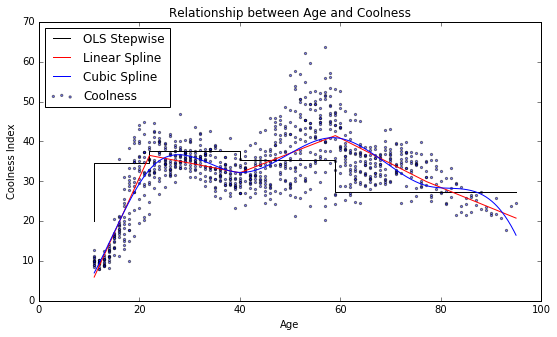

In [38]:
#Part 2d
spline2_coolness=LSQUnivariateSpline(age.values, coolness.values, knots, k=3)
fig=plt.figure(figsize=(9,5))
plt.scatter(age, coolness, s=5, alpha=0.5)
plt.step(age_step, cool_step, 'k-', label="OLS Stepwise")
plt.plot(age_vec, spline_cool(age_vec), 'red', label="Linear Spline")
plt.plot(age_vec, spline2_coolness(age_vec), 'blue', label="Cubic Spline")
plt.title("Relationship between Age and Coolness")
plt.xlabel('Age')
plt.ylabel("Coolness Index")
plt.legend(loc='upper left')


print("The predicted coolness of a 73-year old is", spline2_coolness(73))